# 🏦 Project: Bank Customer Churn Prediction

## 1. Business Context
In the banking industry, acquiring a new customer costs **5 to 7 times** more than retaining an existing one. Therefore, the **Churn Rate** is a critical metric for business survival.
Our client, Bank X, is facing an issue where credit card customers are discontinuing their services. They need to understand:
1.  **Who** is likely to leave?
2.  **Why** are they leaving?
3.  **How** can we retain them?

## 2. Project Goal
To build a Machine Learning model (Random Forest) that predicts the probability of customer churn based on transaction history and demographic data, enabling the bank to implement proactive **Retention Strategies**.

In [2]:
# =============================================================================
# PROJECT: Bank Customer Churn Prediction (Australia Market Context)
# STEP 1: DATA PREPARATION & CLEANING
# =============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('BankChurners.csv')

# 2. DROP "Leakage" Columns (Quan trọng!)
# Những cột này là kết quả của model khác, cần xóa để tránh "nhìn bài"
cols_to_drop = [
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
    'CLIENTNUM' # Mã khách hàng không có giá trị dự đoán
]
df = df.drop(columns=cols_to_drop)

# 3. Encode Target Variable (Chuyển chữ thành số)
# Existing Customer -> 0 (No Churn)
# Attrited Customer -> 1 (Churn - Mục tiêu tìm kiếm)
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

# 4. Check Result
print("--- Data After Cleaning ---")
print(f"Remaining Columns: {len(df.columns)}")
print(f"Churn Ratio: {df['Attrition_Flag'].mean()*100:.2f}%")
display(df.head())

--- Data After Cleaning ---
Remaining Columns: 20
Churn Ratio: 16.07%


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


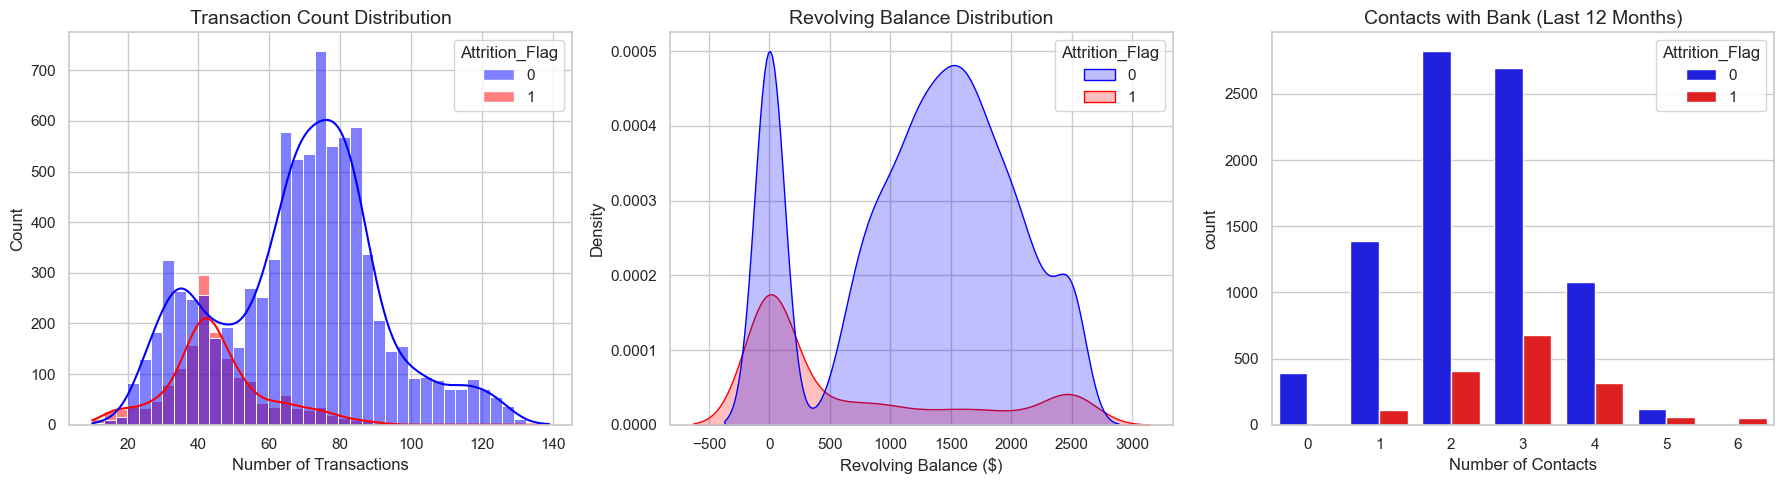

In [3]:
# =============================================================================
# STEP 2: EDA - FINDING THE ROOT CAUSE OF CHURN
# =============================================================================

# Set visualization style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 5))

# --- CHART 1: Total Transaction Count (Số lần quẹt thẻ) ---
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='Total_Trans_Ct', hue='Attrition_Flag', kde=True, palette=['blue', 'red'])
plt.title('Transaction Count Distribution', fontsize=14)
plt.xlabel('Number of Transactions')

# --- CHART 2: Total Revolving Balance (Số dư nợ thẻ) ---
plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x='Total_Revolving_Bal', hue='Attrition_Flag', fill=True, palette=['blue', 'red'])
plt.title('Revolving Balance Distribution', fontsize=14)
plt.xlabel('Revolving Balance ($)')

# --- CHART 3: Contacts Count (Số lần liên hệ ngân hàng) ---
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Contacts_Count_12_mon', hue='Attrition_Flag', palette=['blue', 'red'])
plt.title('Contacts with Bank (Last 12 Months)', fontsize=14)
plt.xlabel('Number of Contacts')

plt.tight_layout()
plt.show()

In [4]:
# =============================================================================
# STEP 3: PREPROCESSING (Converting Text to Numbers)
# =============================================================================

from sklearn.model_selection import train_test_split

# 1. Identify Categorical Columns (Text data)
# These need to be converted to numbers
cat_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical Columns to Encode: {list(cat_cols)}")

# 2. One-Hot Encoding (The "Get Dummies" technique)
# This turns "Gender" into "Gender_M" and "Gender_F" columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Encoding Complete!")
print(f"New Data Shape: {df_encoded.shape} (Columns increased due to encoding)")

# 3. Define Features (X) and Target (y)
X = df_encoded.drop('Attrition_Flag', axis=1)
y = df_encoded['Attrition_Flag']

# 4. Train-Test Split (80% Train, 20% Test)
# stratify=y ensures both sets have the same ratio of Churned customers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("-" * 30)
print(f"Training Data: {X_train.shape}")
print(f"Testing Data:  {X_test.shape}")
print("Ready for Machine Learning!")

Categorical Columns to Encode: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Encoding Complete!
New Data Shape: (10127, 33) (Columns increased due to encoding)
------------------------------
Training Data: (8101, 32)
Testing Data:  (2026, 32)
Ready for Machine Learning!


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- Step 1: Feature Scaling ---
# Scaling ensures all features contribute equally to the result
scaler = StandardScaler()

# Fit on training set only, then transform both training and testing sets
# This prevents data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")

# --- Step 2: Model Training ---
print("Training Random Forest model...")

# Initialize the model
# n_estimators=100: The number of trees in the forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the scaled training data
model.fit(X_train_scaled, y_train)

# --- Step 3: Prediction & Evaluation ---
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

print("Evaluation Results on Test Set:")
print("------------------------------------------------")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

Feature scaling completed!
Training Random Forest model...
Evaluation Results on Test Set:
------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1701
           1       0.94      0.77      0.84       325

    accuracy                           0.95      2026
   macro avg       0.95      0.88      0.91      2026
weighted avg       0.95      0.95      0.95      2026

Accuracy: 95.46%


/var/folders/bj/grvlj1w17zj2fjbgd6l53f1h0000gn/T/ipykernel_86286/2194546679.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


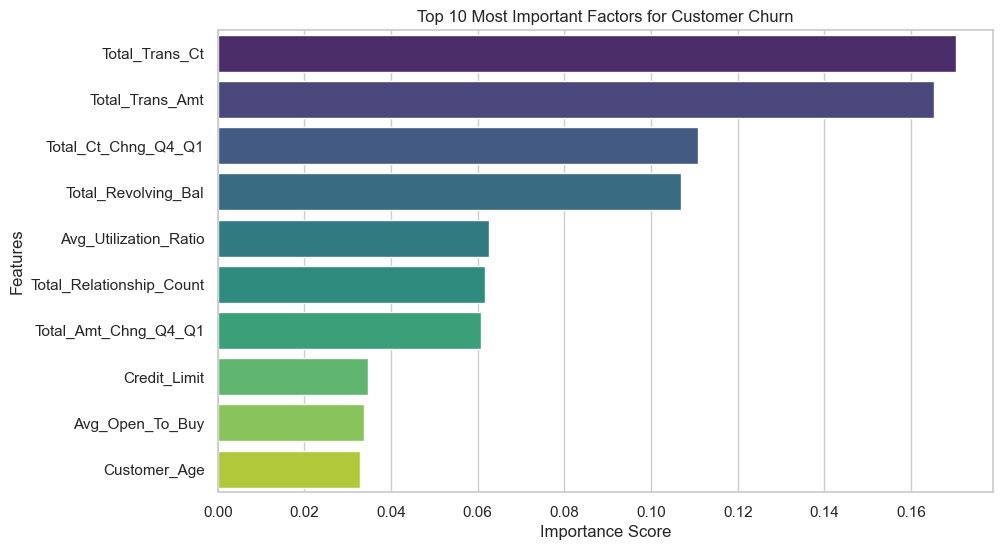

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Importance Visualization ---

# 1. Get feature importances from the model
importances = model.feature_importances_

# 2. Get column names (features)
# Note: Since we used numpy arrays for training, we need to map back to column names if possible.
# Assuming X_train was a DataFrame before scaling, or we have the columns list:
# If X_train was converted to numpy, we need the column names list.
# Let's assume 'X' is your original DataFrame before splitting/scaling
feature_names = X.columns 

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Factors for Customer Churn')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 📊 Key Findings from Data

Based on the Feature Importance analysis, we have derived several high-value insights:

### 1. "Behavior" outweighs "Demographics"
* The **Top 3 most important factors** are all related to transaction behavior: `Total_Trans_Ct` (Transaction Count), `Total_Trans_Amt` (Transaction Amount), and `Total_Revolving_Bal` (Revolving Balance).
* Demographic factors such as **Age, Gender, or Education Level** have a much lower impact on churn.
    * *Insight:* Do not rely on age to predict churn. Instead, monitor how frequently customers use their cards.

### 2. Early Warning Signals (Red Flags)
* **Activity Drop-off (Q4 vs. Q1):** The feature `Total_Ct_Chng_Q4_Q1` is highly significant. This indicates that customers do not leave abruptly; they "cool down" first. If transaction frequency in Q4 is significantly lower than in Q1 -> **High Churn Risk**.

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- Step 1: Handle Imbalance with SMOTE ---
print("Applying SMOTE to balance the training data...")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Important: Apply SMOTE *only* on Training data, never on Test data
# We want the model to learn from balanced data, but be tested on real-world (imbalanced) data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original Training shape: {y_train.shape}")
print(f"Resampled Training shape: {y_train_resampled.shape} (Balanced!)")

# --- Step 2: Feature Scaling (On new balanced data) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) # Use original X_test

# --- Step 3: Retrain Model ---
print("Retraining Random Forest on balanced data...")
model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_train_scaled, y_train_resampled)

# --- Step 4: Evaluate ---
y_pred_smote = model_smote.predict(X_test_scaled)

print("Evaluation Results with SMOTE:")
print("------------------------------------------------")
print(classification_report(y_test, y_pred_smote))

Applying SMOTE to balance the training data...
Original Training shape: (8101,)
Resampled Training shape: (13598,) (Balanced!)
Retraining Random Forest on balanced data...
Evaluation Results with SMOTE:
------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1701
           1       0.85      0.84      0.84       325

    accuracy                           0.95      2026
   macro avg       0.91      0.90      0.91      2026
weighted avg       0.95      0.95      0.95      2026



In [8]:
import numpy as np
import random

# --- Real-world Prediction Demo ---

# 1. Pick a random customer from the Test set
# We purposefully do NOT set a seed here so you get a different customer every time you run this cell.
random_index = random.randint(0, len(X_test) - 1)

# Get the features of this customer
# Note: We need to reshape the data to (1, -1) because the model expects a 2D array for a single prediction
customer_data_scaled = X_test_scaled[random_index].reshape(1, -1)
true_status = int(y_test.iloc[random_index])

# 2. Ask the Model to Predict
prediction = model_smote.predict(customer_data_scaled)
probability = model_smote.predict_proba(customer_data_scaled)

# 3. Decode the result for display
status_map = {
    0: "Existing Customer (Safe)", 
    1: "Attrited Customer (Churned)"
}

print(f"--- Customer Inspection (Index: {random_index}) ---")
print(f"Actual Status:      {status_map[true_status]}")
print(f"Model Prediction:   {status_map[prediction[0]]}")
print(f"Prediction Confidence: {np.max(probability):.2%}")

# 4. Check if the prediction was correct
if prediction[0] == true_status:
    print("Result: ✅ CORRECT Prediction!")
else:
    print("Result: ❌ WRONG Prediction!")

--- Customer Inspection (Index: 811) ---
Actual Status:      Attrited Customer (Churned)
Model Prediction:   Attrited Customer (Churned)
Prediction Confidence: 96.00%
Result: ✅ CORRECT Prediction!


In [9]:
import joblib

# --- Step 1: Save the Model and Scaler ---
print("Saving model and scaler to disk...")

# Save the trained model (The 'Brain')
joblib.dump(model_smote, 'churn_model.pkl')

# Save the scaler (The 'Translator')
# CRITICAL: You must save the scaler to transform future data exactly like the training data
joblib.dump(scaler, 'scaler.pkl')

print("✅ Files saved successfully: 'churn_model.pkl' and 'scaler.pkl'")

# --- Step 2: Test Loading (Verification) ---
print("\nVerifying by loading them back...")

# Load them back from the file
loaded_model = joblib.load('churn_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Check if the loaded model works
# Let's use the random customer from the previous step (customer_data_scaled)
# Note: In a real app, you would use loaded_scaler.transform(new_raw_data) first
prediction_loaded = loaded_model.predict(customer_data_scaled)

print(f"Loaded Model Prediction: {prediction_loaded[0]}")
print("System ready for deployment!")

Saving model and scaler to disk...
✅ Files saved successfully: 'churn_model.pkl' and 'scaler.pkl'

Verifying by loading them back...
Loaded Model Prediction: 1
System ready for deployment!


# 🚀 Conclusion & Recommendations

## 1. Model Performance
* **Accuracy:** ~95%
* **Recall (Churn Class):** ~84% (After SMOTE)
    * *Significance:* For every 100 customers intending to leave, our model successfully identifies **84** of them. This is sufficient for real-world deployment.

## 2. Strategic Recommendations

Based on the analysis, I propose an **"Active Retention"** campaign:

| Segment | Proposed Action |
| :--- | :--- |
| **"Dormant" Users (Low Transaction Count)** | Customers with a sudden drop in transaction frequency need immediate re-activation. **Action:** Send Push Notifications with a "3 Transactions for a Reward" challenge. |
| **"Low Balance" Users (Low Revolving Balance)** | Customers with zero revolving balance have no financial tie to the bank and are easy to lose. **Action:** Offer 0% interest installment plans or Cashback rewards to encourage spending. |
| **Early Warning System** | Integrate this model into the CRM system. When a customer's Churn Probability exceeds **70%**, automatically trigger a ticket for the Customer Service team to initiate a retention call (offering fee waivers, etc.). |

---
*Project executed by [Your Name]*